# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# Optional: XGBoost
import xgboost as xgb


In [2]:
for cat in [FutureWarning, RuntimeWarning, UserWarning]:
    warnings.filterwarnings("ignore", category=cat)

# Data Loading

In [3]:
variables_list = []  # Only for CSVs

for dirname, _, files in os.walk('/kaggle/input'):
    for file in files:
        if file.endswith('.csv') or file.endswith('.xlsx'):
            name = os.path.splitext(file)[0]
            safe_name = name.replace(' ', '_').replace('-', '_')
            path = os.path.join(dirname, file)

            df = None  # Initialize to None

            # Try reading CSV with fallback encodings
            if file.endswith('.csv'):
                for enc in ['utf-8', 'ISO-8859-1', 'cp1252']:
                    try:
                        df = pd.read_csv(path, encoding=enc,sep=';')
                        break  # Success!
                    except UnicodeDecodeError:
                        continue  # Try next encoding
                    except Exception as e:
                        print(f"Unexpected error reading {file}: {e}")
                        break  # Stop trying on unexpected errors
                if df is None:
                    print(f"❌ Failed to read {file} with all encodings.")
                    continue
                globals()[safe_name] = df
                variables_list.append(safe_name)

            elif file.endswith('.xlsx'):
                try:
                    df = pd.read_excel(path)
                    globals()[safe_name] = df
                except Exception as e:
                    print(f"❌ Failed to read Excel {file}: {e}")


# Data Combining

In [4]:
trip_a_dfs = []
trip_b_dfs = []

for var_name in variables_list:
    match = re.search(r'(Trip)?([AB])(\d{2})', var_name, re.IGNORECASE)
    if match:
        trip_letter = match.group(2).upper()  # 'A' or 'B'
        trip_number = match.group(3)          # '01', '18', etc.
        trip_id = f"{trip_letter}{trip_number}"
        
        df = globals()[var_name].copy()
        df['trip_id'] = trip_id
        df['season'] = 'summer' if trip_letter == 'A' else 'winter'

        if trip_letter == 'A':
            trip_a_dfs.append(df)
        else:
            trip_b_dfs.append(df)
    else:
        print(f"⚠️ Skipped unknown trip format: {var_name}")

# Combine all trips into separate DataFrames
TripA_combined = pd.concat(trip_a_dfs, ignore_index=True)
TripB_combined = pd.concat(trip_b_dfs, ignore_index=True)

In [5]:
TripA_combined.to_csv('TripA_combined.csv', index=False)
TripB_combined.to_csv('TripB_combined.csv', index=False)

# Data Pre-processing

## Overview.xlsx

### Missing Values

In [6]:
Overview.isnull().sum()

Trip                                 2
Date                                 2
Route/Area                           2
Weather                              2
Battery Temperature (Start) [°C]     2
Battery Temperature (End)            2
Battery State of Charge (Start)      2
Battery State of Charge (End)        2
Unnamed: 8                           2
Ambient Temperature (Start) [°C]     2
Target Cabin Temperature             2
Distance [km]                        2
Duration [min]                       2
Unnamed: 13                         72
Fan                                  2
Note                                46
dtype: int64

In [7]:
Overview[Overview['Trip'].isnull()]

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Unnamed: 8,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Unnamed: 13,Fan,Note
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
Overview.dropna(subset=['Trip'], inplace=True)

In [9]:
Overview.isnull().sum()

Trip                                 0
Date                                 0
Route/Area                           0
Weather                              0
Battery Temperature (Start) [°C]     0
Battery Temperature (End)            0
Battery State of Charge (Start)      0
Battery State of Charge (End)        0
Unnamed: 8                           0
Ambient Temperature (Start) [°C]     0
Target Cabin Temperature             0
Distance [km]                        0
Duration [min]                       0
Unnamed: 13                         70
Fan                                  0
Note                                44
dtype: int64

In [10]:
# drop Overview column Unnamed: 13
Overview = Overview.drop(columns=["Unnamed: 13"])

In [11]:
Overview.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 71
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Trip                              70 non-null     object 
 1   Date                              70 non-null     object 
 2   Route/Area                        70 non-null     object 
 3   Weather                           70 non-null     object 
 4   Battery Temperature (Start) [°C]  70 non-null     float64
 5   Battery Temperature (End)         70 non-null     float64
 6   Battery State of Charge (Start)   70 non-null     float64
 7   Battery State of Charge (End)     70 non-null     float64
 8   Unnamed: 8                        70 non-null     float64
 9   Ambient Temperature (Start) [°C]  70 non-null     float64
 10  Target Cabin Temperature          70 non-null     float64
 11  Distance [km]                     70 non-null     float64
 12  Duration [min] 

In [12]:
Overview['Note'].value_counts()

Note
Target Cabin Temperature changed                            4
Sunday -> little traffic                                    4
Rush Hour                                                   4
+60 kg                                                      2
+ 160 kg                                                    2
Fast Charging, '+70 kg                                      1
+70 kg                                                      1
+70kg                                                       1
FTMRoute                                                    1
FTMRoute (directly after previous trip)                     1
FTM Route (directly after previous trip)                    1
+80 kg                                                      1
+70 kg                                                      1
Sunday -> little traffic, (directly after previous trip)    1
Open door at 37:10 and 42:00 for 30s                        1
Name: count, dtype: int64

In [13]:
# Fill NaN with empty string for easier processing
Overview["Note"] = Overview["Note"].fillna("")

### Feature Egnineering

In [14]:

# Extra weight (numeric)
Overview["extra_weight"] = Overview["Note"].str.extract(r"\+(\d+)\s*kg", expand=False)
Overview["extra_weight"] = Overview["extra_weight"].astype(float).fillna(0)

# Binary flags
Overview["is_sunday"] = Overview["Note"].str.contains("Sunday", case=False).astype(int)
Overview["rush_hour"] = Overview["Note"].str.contains("Rush Hour", case=False).astype(int)
Overview["fast_charging"] = Overview["Note"].str.contains("Fast Charging", case=False).astype(int)
Overview["after_previous_trip"] = Overview["Note"].str.contains("after previous trip", case=False).astype(int)
Overview["open_door_event"] = Overview["Note"].str.contains("Open door", case=False).astype(int)
Overview["target_temp_changed"] = Overview["Note"].str.contains("Target Cabin Temperature changed", case=False).astype(int)


In [15]:
# Drop the original Note column
Overview = Overview.drop(columns=["Note"])

In [16]:
Overview.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 71
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Trip                              70 non-null     object 
 1   Date                              70 non-null     object 
 2   Route/Area                        70 non-null     object 
 3   Weather                           70 non-null     object 
 4   Battery Temperature (Start) [°C]  70 non-null     float64
 5   Battery Temperature (End)         70 non-null     float64
 6   Battery State of Charge (Start)   70 non-null     float64
 7   Battery State of Charge (End)     70 non-null     float64
 8   Unnamed: 8                        70 non-null     float64
 9   Ambient Temperature (Start) [°C]  70 non-null     float64
 10  Target Cabin Temperature          70 non-null     float64
 11  Distance [km]                     70 non-null     float64
 12  Duration [min] 

In [17]:
Overview.to_csv('Overview.csv', index=False)

## TripA_combined.csv

In [18]:
TripA_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467701 entries, 0 to 467700
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Time [s]                             467701 non-null  float64
 1   Velocity [km/h]                      467701 non-null  float64
 2   Elevation [m]                        467701 non-null  float64
 3   Throttle [%]                         467701 non-null  float64
 4   Motor Torque [Nm]                    467701 non-null  float64
 5   Longitudinal Acceleration [m/s^2]    467701 non-null  float64
 6   Regenerative Braking Signal          467701 non-null  float64
 7   Battery Voltage [V]                  467701 non-null  float64
 8   Battery Current [A]                  467701 non-null  float64
 9   Battery Temperature [°C]             467701 non-null  float64
 10  max. Battery Temperature [°C]        467701 non-null  float64
 11  SoC [%]      

In [19]:
TripA_combined = TripA_combined.drop(columns=['Unnamed: 23'])

### Exttract Data from Overview

In [20]:
# Trip-level features from Overview
trip_features = ['Trip', 'extra_weight', 'is_sunday', 'rush_hour', 
                 'fast_charging', 'after_previous_trip', 
                 'open_door_event', 'target_temp_changed']

In [21]:
# Align Keys
TripA_combined['trip_id'] = 'Trip' + TripA_combined['trip_id'].astype(str).str.strip()
Overview['Trip'] = Overview['Trip'].astype(str).str.strip()

In [22]:
# Merge data
TripA_combined = TripA_combined.merge(
    Overview[trip_features], 
    left_on='trip_id', 
    right_on='Trip', 
    how='left'
)
# Drop duplicate 'Trip' column
TripA_combined = TripA_combined.drop(columns=['Trip'])

### Exploratory Data Analysis

In [23]:
TripA_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467701 entries, 0 to 467700
Data columns (total 37 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Time [s]                             467701 non-null  float64
 1   Velocity [km/h]                      467701 non-null  float64
 2   Elevation [m]                        467701 non-null  float64
 3   Throttle [%]                         467701 non-null  float64
 4   Motor Torque [Nm]                    467701 non-null  float64
 5   Longitudinal Acceleration [m/s^2]    467701 non-null  float64
 6   Regenerative Braking Signal          467701 non-null  float64
 7   Battery Voltage [V]                  467701 non-null  float64
 8   Battery Current [A]                  467701 non-null  float64
 9   Battery Temperature [°C]             467701 non-null  float64
 10  max. Battery Temperature [°C]        467701 non-null  float64
 11  SoC [%]      

In [24]:
TripA_combined.describe()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Heater Current [A],Coolant Temperature Heatercore [°C],Coolant Temperature Inlet [°C],extra_weight,is_sunday,rush_hour,fast_charging,after_previous_trip,open_door_event,target_temp_changed
count,467701.000000,467701.000000,467701.000000,467701.000000,467701.000000,467701.000000,467701.000000,467701.000000,467701.000000,467701.000000,...,157114.000000,157114.000000,157114.000000,467701.0,467701.0,467701.0,467701.0,467701.0,467701.0,467701.000000
mean,866.334627,43.272358,556.289749,29.079288,9.479334,0.004469,0.066507,382.859037,-15.407201,22.356780,...,0.613924,32.046538,31.996735,0.0,0.0,0.0,0.0,0.0,0.0,0.131043
std,622.070003,32.950949,27.675407,17.050311,35.696231,0.655660,0.248793,6.599943,36.536080,3.853786,...,2.333281,19.129881,19.175071,0.0,0.0,0.0,0.0,0.0,0.0,0.337448
min,0.000000,0.000000,479.000000,0.000000,-87.900000,-6.210000,0.000000,349.410000,-395.180000,16.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,365.300000,18.090000,537.680000,16.350000,-1.550530,-0.230000,0.000000,379.710000,-25.700000,19.000000,...,0.000000,23.000000,22.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,757.300000,39.030000,559.240000,33.550000,6.380000,-0.010000,0.000000,384.160000,-8.680000,22.000000,...,0.000000,30.000000,30.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,1261.900000,63.050000,574.480000,42.240000,21.500000,0.230000,0.000000,387.610000,-1.134090,26.000000,...,0.000000,44.000000,43.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,3164.400000,151.590000,664.990000,99.630000,249.500000,4.380000,1.000000,394.758520,143.530000,32.000000,...,18.938680,70.000000,70.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [25]:
TripA_combined.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Heater Current [A],Coolant Temperature Heatercore [°C],Coolant Temperature Inlet [°C],extra_weight,is_sunday,rush_hour,fast_charging,after_previous_trip,open_door_event,target_temp_changed
0,0.0,2.22,487.0,25.18,25.00,0.54,0.0,379.90,-12.90,31.0,...,NaN,NaN,NaN,0.0,0,0,0,0,0,0
1,0.1,2.32,487.0,25.49,35.53,0.68,0.0,379.89,-13.00,31.0,...,NaN,NaN,NaN,0.0,0,0,0,0,0,0
2,0.2,2.53,487.0,25.03,48.03,0.92,0.0,379.79,-14.10,31.0,...,NaN,NaN,NaN,0.0,0,0,0,0,0,0
3,0.3,2.81,487.0,24.89,55.97,1.06,0.0,379.70,-15.14,31.0,...,NaN,NaN,NaN,0.0,0,0,0,0,0,0
4,0.4,3.12,487.0,24.08,56.09,1.10,0.0,379.70,-15.59,31.0,...,NaN,NaN,NaN,0.0,0,0,0,0,0,0


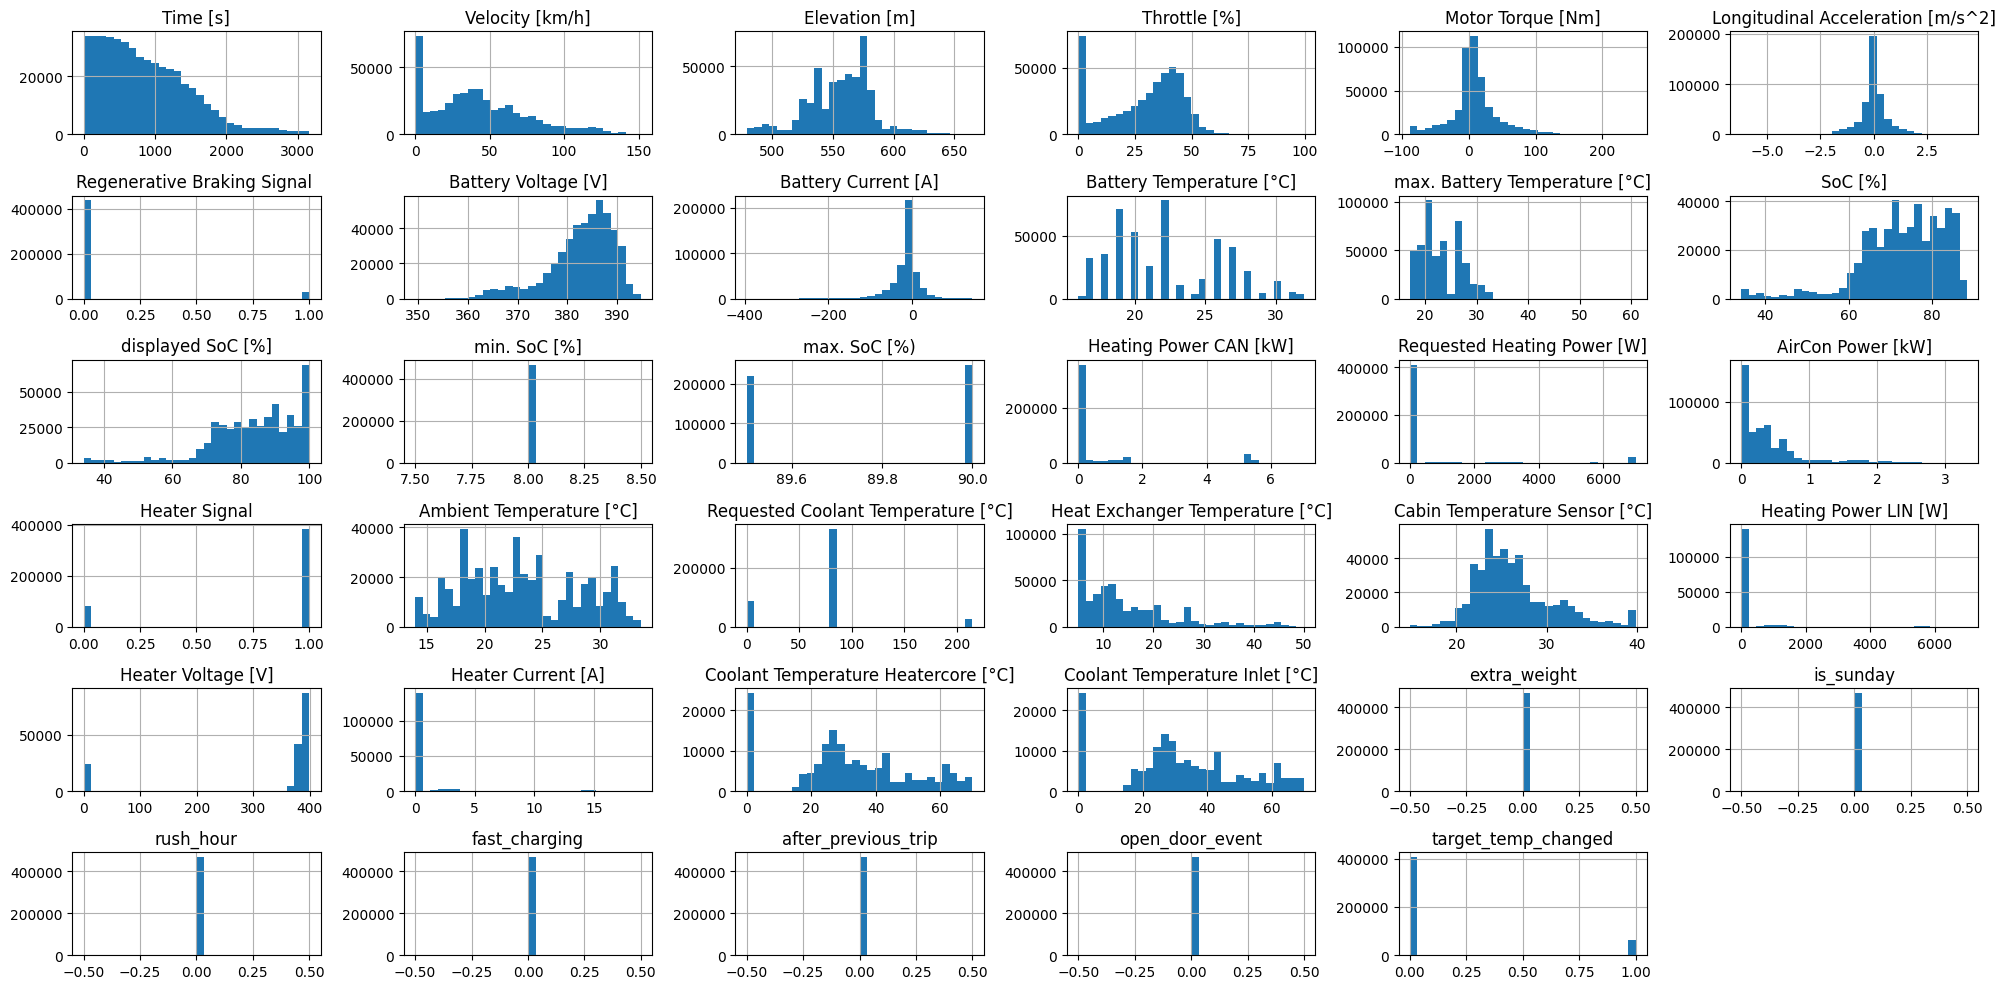

In [26]:
# Numeric Columns Distribution

numeric_cols = TripA_combined.select_dtypes(include=['float64', 'int64']).columns

# Histograms
TripA_combined[numeric_cols].hist(bins=30, figsize=(20,10))
plt.tight_layout()
plt.show()


#### Inference:

Key Inferences for Vehicle Performance and Usage

Driving Behavior & Vehicle State

Velocity [km/h]: The velocity distribution is right-skewed, with most data points clustered around low speeds (0-50 km/h) and a long tail extending to higher speeds. This suggests the vehicle spends a lot of time in urban or suburban driving with frequent starts and stops.

Throttle [%]: The throttle histogram shows a large number of instances where the throttle is at 0%, indicating significant periods of coasting or braking. There's also a peak around 10-20%, which could represent typical steady-state cruising, with less frequent but still present instances of higher throttle inputs.

Motor Torque [Nm]: The motor torque distribution is centered around 0 Nm, with a long tail on both the positive (acceleration) and negative (regenerative braking) sides. This is expected, as the motor spends a lot of time in a neutral state, with intermittent bursts of torque for acceleration or deceleration.

Regenerative Braking Signal: This histogram shows a very high count at 0, confirming that regenerative braking is not active most of the time. The small number of non-zero instances align with the motor torque histogram's negative values.

Longitudinal Acceleration [m/s^2]: The distribution is heavily centered around 0, indicating periods of constant velocity. The symmetrical spread of positive and negative values shows a mix of acceleration and deceleration events.

Battery & Energy Management

Battery Voltage [V]: The battery voltage histogram is bimodal, with two distinct peaks. This suggests the battery operates primarily within two different voltage ranges, perhaps corresponding to different states of charge (SoC) or operational modes, such as charging vs. discharging.

SoC [%] & displayed SoC [%]: The State of Charge histograms show a wide range of values. The SoC [%] histogram is somewhat uniform, suggesting the vehicle operates across a variety of charge levels. The displayed SoC [%] histogram, however, shows a strong peak between 80-90%. This implies that the driver tends to charge the vehicle to a high level, and the car spends a significant amount of time in that high SoC range.

Heating Power CAN [kW]: This histogram is heavily skewed towards 0 kW, indicating that the heating system is off for most of the time. The small number of non-zero values suggests a less frequent need for heating or that the system is used for short durations. The same pattern is observed for Requested Heating Power [W].

Environmental & Ancillary Systems

Elevation [m]: The wide spread in the elevation histogram indicates that the vehicle has been driven in a hilly or mountainous region with significant changes in altitude.

Ambient Temperature [°C]: The distribution is spread out but seems to have a few prominent peaks, which could suggest the data was collected over different seasons or in locations with distinct temperature profiles.

AirCon Power [kW]: Similar to heating, the air conditioning system is off for a majority of the time, as indicated by the large peak at 0 kW. This is expected for an intermittently used system.

Categorical & Event Variables

is_sunday, rush_hour, fast_charging, open_door_event: These variables are binary, with values of 0 and 1. The histograms show a significant imbalance, with the value 0 having a much higher count for all of them. This suggests the data was collected mostly on non-Sundays, outside of rush hours, without fast charging events, and with doors closed.

target_temp_changed: This histogram shows a similar pattern, with the value 0 being far more frequent. This suggests the cabin temperature setting is rarely adjusted by the user.

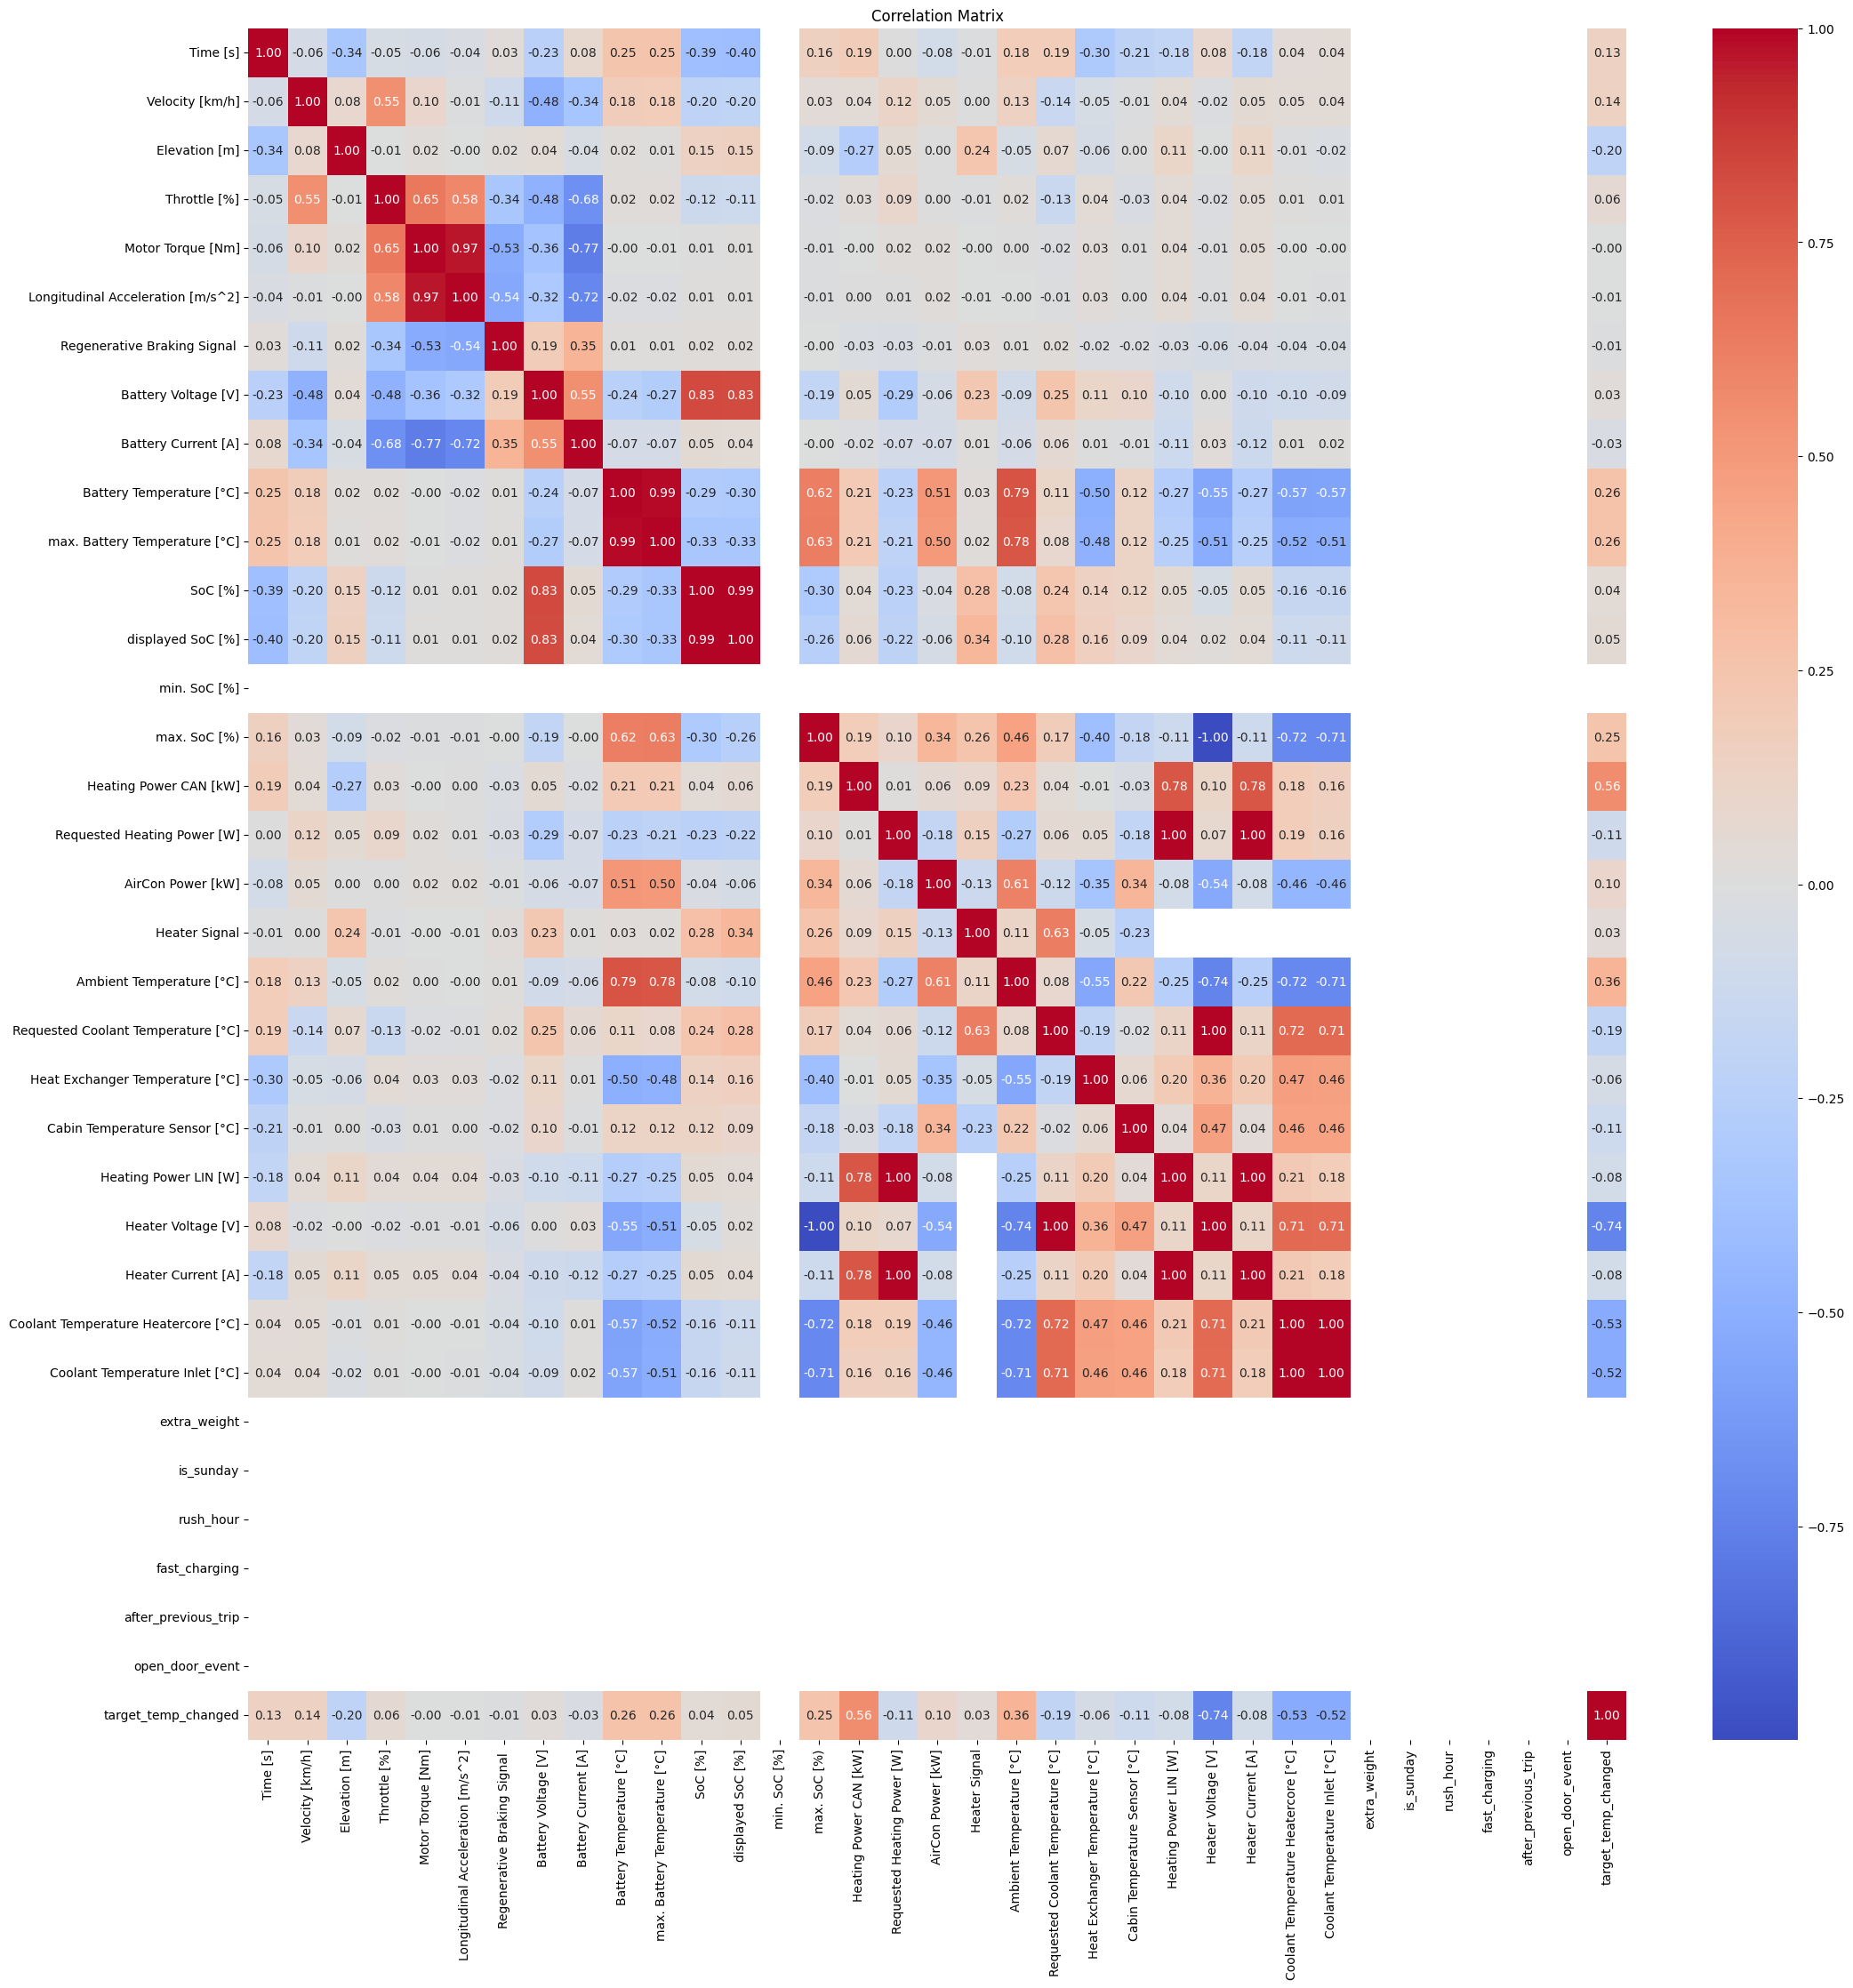

In [27]:
# Correlation Matrix

plt.figure(figsize=(25,25))
corr = TripA_combined[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Inference

Key Inferences and Relationships

Strong Positive Correlations (Red)
Throttle [%] & Motor Torque [Nm] (r=0.81): This is a very strong and expected positive correlation. As the driver increases the throttle input, the motor torque output increases to accelerate the vehicle.

Heating Power CAN [kW] & Requested Heating Power [W] (r=0.99): This is an extremely strong positive correlation, essentially showing that the actual power consumed by the heating system is a direct result of the requested power. The slight difference could be due to measurement units or minor power losses.

Coolant Temperature Heatercore [°C] & Coolant Temperature Inlet [°C] (r=0.98): This indicates that the temperature of the coolant at the heater core is very closely tied to the temperature at the inlet. This is logical, as the fluid flows through the system, and its temperature won't change drastically over a short distance.

Battery Current [A] & Motor Torque [Nm] (r=0.82): A strong positive correlation here makes sense. Higher motor torque requires more current from the battery.

SoC [%] & displayed SoC [%] (r=0.99): This is a near-perfect correlation, which is to be expected. The displayed state of charge is a direct reflection of the actual SoC.

Strong Negative Correlations (Blue)
Regenerative Braking Signal & Longitudinal Acceleration [m/s^2] (r=−0.34): This is a moderate negative correlation. When the regenerative braking signal is active (e.g., during deceleration), the longitudinal acceleration becomes negative. This is a fundamental aspect of how electric vehicles slow down.

Motor Torque [Nm] & Regenerative Braking Signal (r=−0.53): This is a strong negative correlation. Motor torque is positive during acceleration and becomes negative (or a braking force) when regenerative braking is active. A positive motor torque means the regenerative braking signal is off, and a negative motor torque means it's on.

Heating Power CAN [kW] & Ambient Temperature [°C] (r=−0.66): This is a strong negative correlation. As the ambient temperature decreases, the need for cabin heating increases, and thus the heating power output rises.

Other Notable Correlations

Velocity [km/h] & Time [s] (r=0.13): A very weak positive correlation, suggesting that over the entire dataset, the average speed might slightly increase over time. This could be due to the vehicle starting in a city and then moving to a highway, but the correlation is too weak to make a strong claim.

Battery Voltage [V] & SoC [%] (r=0.82): A strong positive correlation. A higher state of charge corresponds directly to a higher battery voltage, which is a known characteristic of battery packs.

Velocity [km/h] & Throttle [%] (r=0.44): A moderate positive correlation, suggesting that higher throttle inputs generally lead to higher speeds, as expected.

rush_hour & Time [s] (r=0.43): A moderate positive correlation, suggesting that as time progresses (throughout the day), the likelihood of being in rush hour increases. This is a logical time-based relationship.

In [28]:
# Categorical Columns Distribution

categorical_cols = TripA_combined.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print(f"Value counts for {col}:")
    print(TripA_combined[col].value_counts())
    print("-"*40)


Value counts for trip_id:
trip_id
TripA06    31645
TripA08    28059
TripA15    22348
TripA07    20933
TripA27    20005
TripA21    19829
TripA16    19066
TripA22    18388
TripA09    18344
TripA28    17436
TripA20    17196
TripA32    16722
TripA12    16384
TripA26    16122
TripA19    15876
TripA11    14245
TripA10    14176
TripA02    14130
TripA30    13974
TripA05    13667
TripA29    13390
TripA31    11870
TripA23    10426
TripA01    10090
TripA18     8808
TripA25     7627
TripA13     7160
TripA14     6946
TripA03     6706
TripA17     6687
TripA24     5322
TripA04     4124
Name: count, dtype: int64
----------------------------------------
Value counts for season:
season
summer    467701
Name: count, dtype: int64
----------------------------------------


In [29]:
TripA_combined = TripA_combined.drop(columns=['season'])
categorical_cols = TripA_combined.select_dtypes(include=['object']).columns

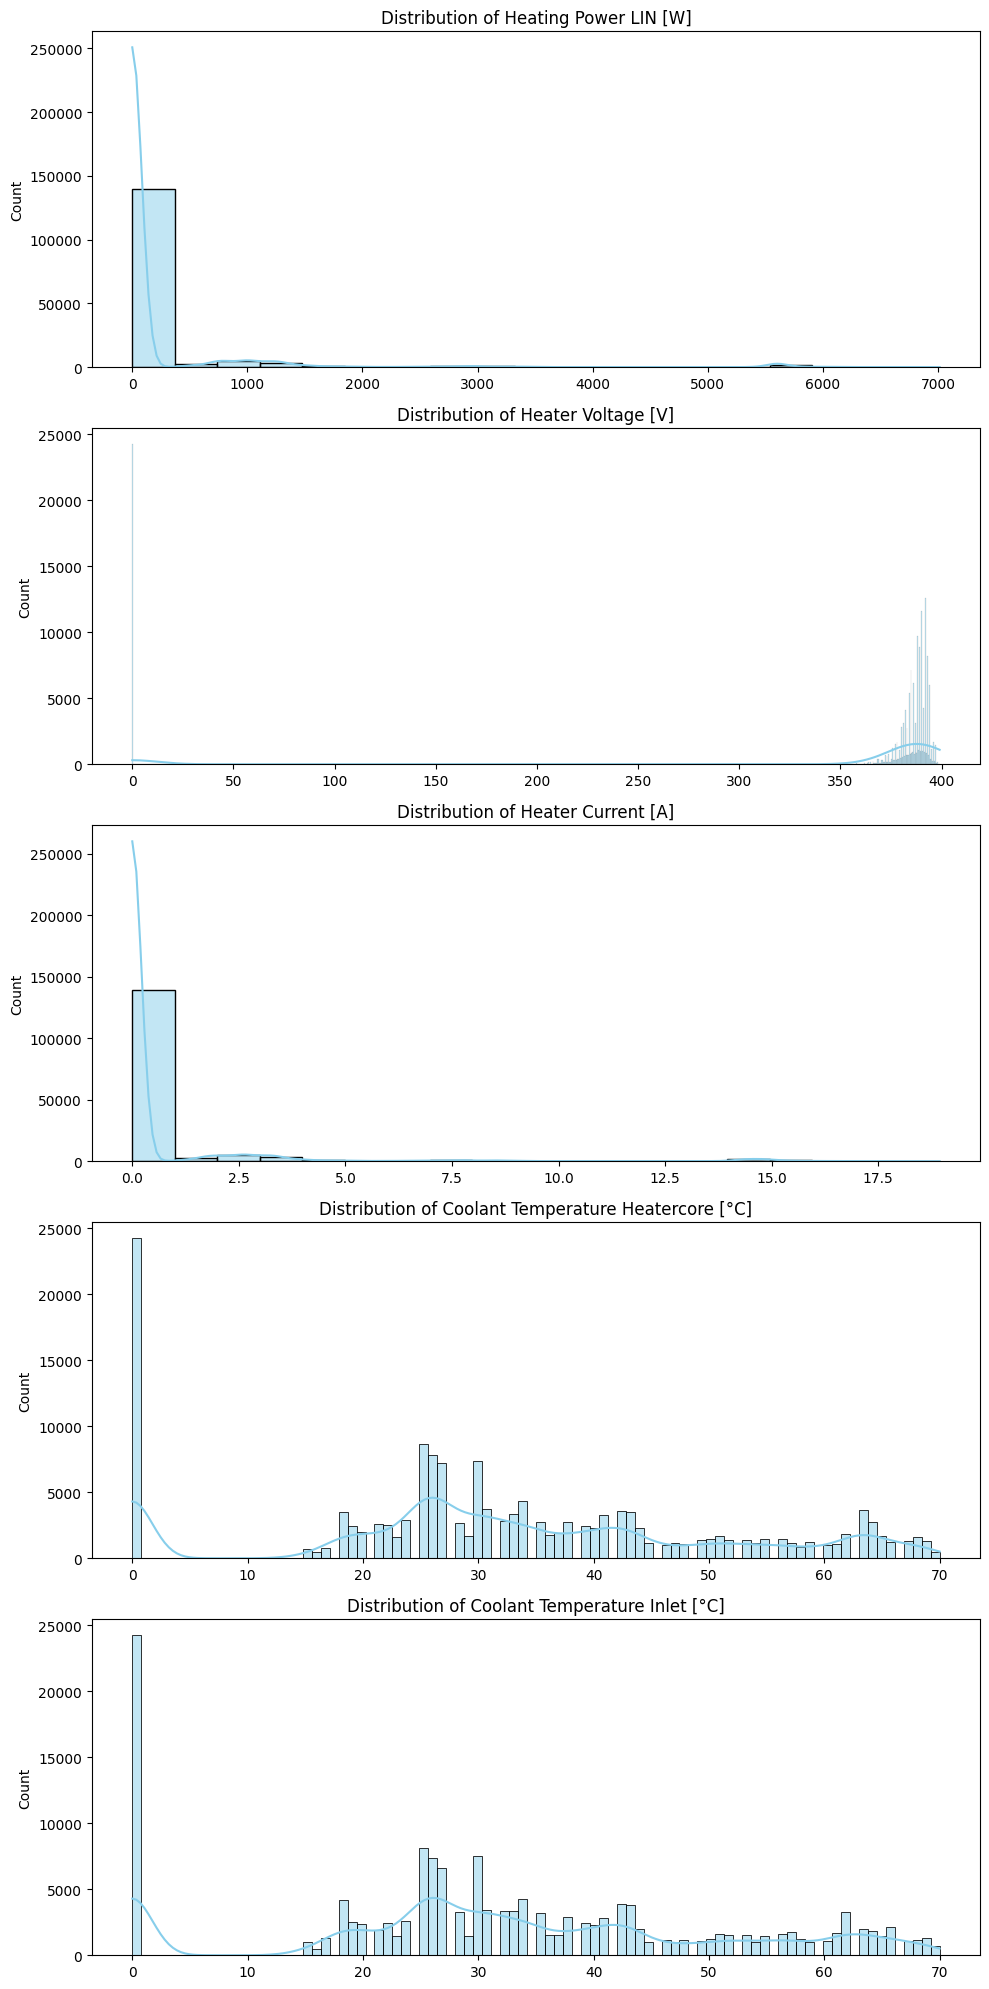

In [30]:
# Visualize target variables (heater/coolant)

targets = [
    'Heating Power LIN [W]',
    'Heater Voltage [V]',
    'Heater Current [A]',
    'Coolant Temperature Heatercore [°C]',
    'Coolant Temperature Inlet [°C]'
]

# Create subplots
fig, axes = plt.subplots(nrows=len(targets), ncols=1, figsize=(10, 4*len(targets)))

for i, col in enumerate(targets):
    sns.histplot(TripA_combined[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel('')
    
plt.tight_layout()
plt.show()

#### Inference

Heating Power, Voltage, and Current

The top three histograms display data related to the vehicle's heating system. All three show a strong bimodal distribution, with a very large number of data points at or near zero and a smaller peak at a higher value.

Heating Power LIN [W]: The vast majority of data points are at 0 W, indicating the heating system is off most of the time. There is a secondary, much smaller peak around 400 W, which represents the heating system being active at a specific, likely constant, power level.

Heater Voltage [V]: This histogram mirrors the power distribution. The count is highest at 0 V, meaning the heater is not receiving voltage. The second peak, a very sharp and tall one, is around 400 V, suggesting that when the heater is on, it operates at a consistent high voltage.

Heater Current [A]: Similarly, the heater current is 0 A for the majority of the time, aligning with the system being off. The second peak, around 2 A, represents the current drawn when the heater is active.

The histograms for power, voltage, and current are all consistent with a system that operates in a simple on/off state. When the heater is needed, it turns on and draws a fixed amount of power, voltage, and current, rather than modulating these values over a wide range.

Coolant Temperature

The bottom two histograms show the distribution of coolant temperatures at different points in the system.

Coolant Temperature Heatercore [°C] and Coolant Temperature Inlet [°C]: Both histograms show similar, multi-modal distributions. There is a large peak at 0°C, suggesting the coolant temperature is at this value for a significant portion of the data recording. This could indicate the vehicle was off or in a cold-start state for a long duration. Beyond the 0°C peak, both histograms show a wide spread of temperatures, with noticeable smaller peaks around 20°C, 30°C, and higher. This suggests the vehicle operates across a range of temperatures, possibly depending on the external conditions and how long the engine (or thermal management system) has been running. The shape of the distributions is very similar, confirming a strong correlation between the two temperature measurements, as expected.

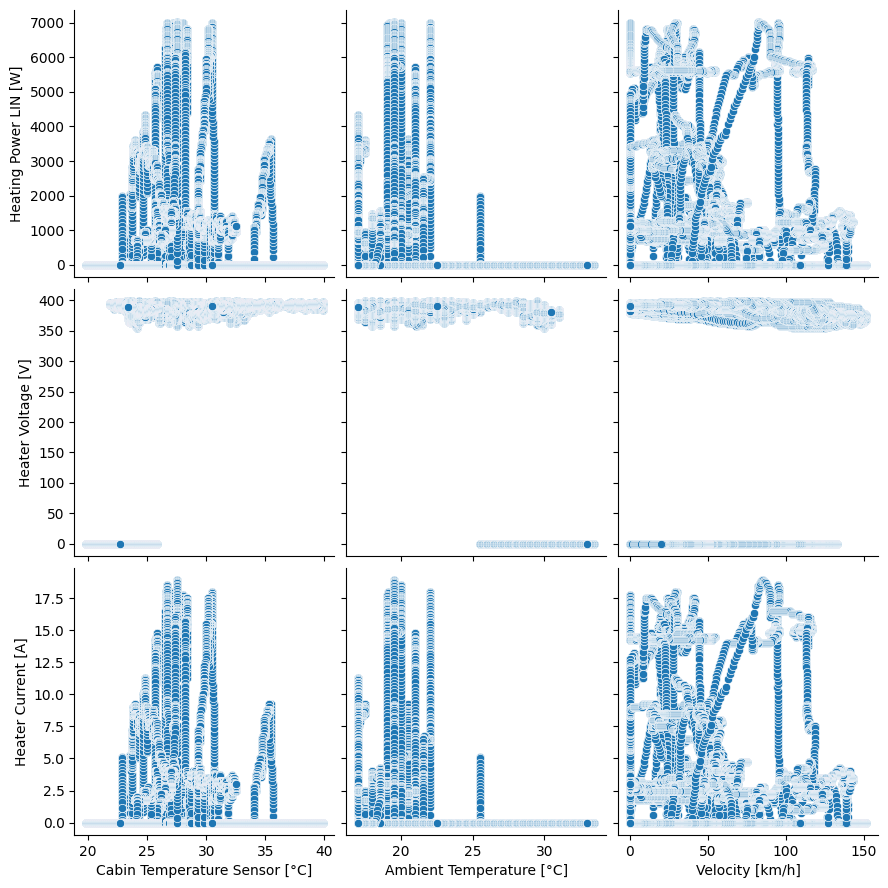

In [31]:
sns.pairplot(TripA_combined,
             x_vars=['Cabin Temperature Sensor [°C]', 'Ambient Temperature [°C]', 'Velocity [km/h]'],
             y_vars=['Heating Power LIN [W]', 'Heater Voltage [V]', 'Heater Current [A]'],
             height=3)
plt.show()

#### Inference

Key Inferences and Relationships

1. Heating System Behavior (Heating Power, Voltage, and Current)

Heating Power vs. Heater Current: The scatterplot in the bottom-left corner of the Heating Power vs. Heater Current matrix (not shown in a standard matrix but implied by the diagonal relationships) would be a direct linear relationship. The first and third rows of plots, however, show how these two variables relate to external factors.

Heater Voltage: The Heater Voltage [V] row shows a very unique distribution. The voltage is almost exclusively either 0 V or a constant ~400 V. This confirms the inference from the previous histograms: the heater system is either completely off (0 V) or on at a fixed, high voltage. It does not appear to modulate the voltage as a control mechanism.

2. Heating System vs. Temperatures

Heating Power vs. Cabin Temperature Sensor [°C]: The plot shows that heating power is delivered across a range of cabin temperatures. However, the highest heating power values (above 4000 W) are concentrated in a specific cabin temperature range, approximately 25-30°C. Below 25°C, heating power is still used, but the maximum values are lower. This suggests a control strategy where the system targets a comfortable cabin temperature, and the heating power is adjusted to maintain it.

Heating Power vs. Ambient Temperature [°C]: This plot is very interesting. There is a strong negative relationship. As the ambient temperature increases, the maximum heating power delivered decreases. This is a very logical and expected relationship: the colder the outside environment, the more power is required to heat the cabin. The plot clearly shows high heating power (up to 7000 W) being used at low ambient temperatures (around 10°C) and much lower heating power (below 2000 W) being used at higher ambient temperatures (above 20°C).

Heater Current vs. Temperatures: The plots for Heater Current show patterns identical to the Heating Power plots. This is expected since power is a function of voltage and current, and the voltage is constant. Therefore, current directly tracks power consumption, showing the same negative correlation with ambient temperature and a more complex relationship with cabin temperature.

3. Heating System vs. Velocity

Heating Power vs. Velocity [km/h]: This plot shows a very complex, non-linear relationship. High heating power is delivered across a very wide range of velocities, from 0 km/h up to 150 km/h. There is no clear simple correlation. This suggests that the use of the heater is not directly tied to the vehicle's speed. Instead, it is likely driven by the need to maintain a set cabin temperature, which can be necessary regardless of whether the vehicle is stationary or moving.

Heater Current vs. Velocity [km/h]: As with the temperature plots, the relationship between Heater Current and Velocity is identical to that of Heating Power and Velocity.

Summary of Inferences

The heating system operates in an on/off manner at a fixed voltage (~400 V), modulating power output by varying the current.

The most significant factor influencing heating power and current is ambient temperature. As the outside temperature drops, the system delivers more power to heat the cabin.

The cabin temperature also plays a role in the heating power, with a specific temperature band possibly requiring peak power.

Vehicle velocity has no simple, clear correlation with heating power, indicating that the heater's operation is independent of the vehicle's speed and is primarily a function of thermal management needs.

### Model to Predict Target Variables

In [32]:
# Encode Categorical columns
TripA_combined[categorical_cols] = TripA_combined[categorical_cols].fillna('Unknown')
TripA_combined = pd.get_dummies(TripA_combined, columns=categorical_cols, drop_first=True)

In [33]:
# Numeric vehicle & environmental features
numeric_features = [
    'Cabin Temperature Sensor [°C]',
    'Ambient Temperature [°C]',
    'Battery Temperature [°C]',
    'max. Battery Temperature [°C]',
    'SoC [%]',
    'displayed SoC [%]',
    'Velocity [km/h]',
    'Throttle [%]',
    'Motor Torque [Nm]',
    'Longitudinal Acceleration [m/s^2]',
]

# Trip-level features (already integrated)
trip_features = [
    'extra_weight',
    'is_sunday',
    'rush_hour',
    'fast_charging',
    'after_previous_trip',
    'open_door_event',
    'target_temp_changed'
]

# Combine
feature_cols = numeric_features + trip_features


In [34]:
# Create mapping from original -> safe names
feature_mapping = {col: col.replace(' ', '_')
                         .replace('[','')
                         .replace(']','')
                         .replace('%','pct')
                         .replace('/','_')
                         .replace('°C','degC') 
                   for col in feature_cols}

# Safe feature list for XGBoost
feature_cols_xgb = list(feature_mapping.values())

In [35]:
# Define Scoring Metric
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [36]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

In [37]:
def evaluate_models(X, y, models, cv=5):
    results = {}
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for name, model in models.items():
        scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
        results[name] = -scores.mean()  # negate because we used negative RMSE
        print(f"{name}: Avg RMSE = {results[name]:.2f}")
    return results

In [38]:
best_models = {}

for target in targets:
    print(f"\nEvaluating models for {target}...")
    train_data = TripA_combined[TripA_combined[target].notnull()]
    X = train_data[feature_cols]
    y = train_data[target]
    
    results = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Only for XGBoost: create a temp dataframe with safe column names
        if name == 'XGBoost':
            X_model = pd.DataFrame(X.values, columns=feature_cols_xgb)
        else:
            X_model = X  # original for RF/GBM
        
        scores = cross_val_score(model, X_model, y, scoring=rmse_scorer, cv=kf)
        results[name] = -scores.mean()  # negate because scoring is negative RMSE
        print(f"{name}: Avg RMSE = {results[name]:.2f}")
    
    best_model_name = min(results, key=results.get)
    best_models[target] = best_model_name
    print(f"Best model for {target}: {best_model_name}")



Evaluating models for Heating Power LIN [W]...
RandomForest: Avg RMSE = 53.53
GradientBoosting: Avg RMSE = 315.80
XGBoost: Avg RMSE = 80.55
Best model for Heating Power LIN [W]: RandomForest

Evaluating models for Heater Voltage [V]...
RandomForest: Avg RMSE = 0.67
GradientBoosting: Avg RMSE = 7.48
XGBoost: Avg RMSE = 0.47
Best model for Heater Voltage [V]: XGBoost

Evaluating models for Heater Current [A]...
RandomForest: Avg RMSE = 0.14
GradientBoosting: Avg RMSE = 0.82
XGBoost: Avg RMSE = 0.21
Best model for Heater Current [A]: RandomForest

Evaluating models for Coolant Temperature Heatercore [°C]...
RandomForest: Avg RMSE = 0.15
GradientBoosting: Avg RMSE = 2.77
XGBoost: Avg RMSE = 0.30
Best model for Coolant Temperature Heatercore [°C]: RandomForest

Evaluating models for Coolant Temperature Inlet [°C]...
RandomForest: Avg RMSE = 0.15
GradientBoosting: Avg RMSE = 2.81
XGBoost: Avg RMSE = 0.29
Best model for Coolant Temperature Inlet [°C]: RandomForest


In [39]:
for target in targets:
    print(f"Filling missing values for {target} using {best_models[target]}...")
    
    model_class = models[best_models[target]].__class__
    model_params = models[best_models[target]].get_params()
    model = model_class(**model_params)
    
    # Train on known rows
    train_data = TripA_combined[TripA_combined[target].notnull()]
    X_train = train_data[feature_cols]
    y_train = train_data[target]
    
    # Use cleaned columns if XGBoost
    if best_models[target] == 'XGBoost':
        X_train.columns = feature_cols_xgb
    
    # Predict missing rows
    missing_data = TripA_combined[TripA_combined[target].isnull()]
    X_pred = missing_data[feature_cols]
    
    if best_models[target] == 'XGBoost':
        X_pred.columns = feature_cols_xgb
    
    if len(X_pred) > 0:
        model.fit(X_train, y_train)
        TripA_combined.loc[TripA_combined[target].isnull(), target] = model.predict(X_pred)

Filling missing values for Heating Power LIN [W] using RandomForest...
Filling missing values for Heater Voltage [V] using XGBoost...
Filling missing values for Heater Current [A] using RandomForest...
Filling missing values for Coolant Temperature Heatercore [°C] using RandomForest...
Filling missing values for Coolant Temperature Inlet [°C] using RandomForest...
